# Image Processing

In [1]:
import cv2
ori_img = cv2.imread('./images/carl.png', 0)
img = cv2.resize(ori_img,None,fx=0.5,fy=0.5)
# print(ori_img.shape)
# print(img.shape)
cv2.imshow('test image', img)
# cv2.imwrite(r'./images/grey_carl.jpg', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im).astype('float')
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2
   
prop = 0.5
# prop: percentage of images to alter (parameter for both noise mask), prop = 1 --> 100% colour inversion for saltnpeppar noise.
varSigma = 1
# varSigma = standard deviation parameter for Gaussian noise, low varSigma --> smoother noise spread.

prop_img = img/255
gauss_noise = add_gaussian_noise(prop_img,prop,varSigma)
cv2.imshow('gaussian noise', gauss_noise)
# cv2.imwrite(r'./images/gauss_carl.jpg', gauss_noise)


snp_noise = add_saltnpeppar_noise(prop_img,prop)
cv2.imshow('saltnpeppar noise', snp_noise)
# cv2.imwrite(r'./images/snp_carl.jpg', snp_noise)

cv2.waitKey(0)
cv2.destroyAllWindows()



In [3]:
img_gray_arr = np.asarray(prop_img) # convert input into computable array
x = np.rint(img_gray_arr) # round elements of array to nearest integer to determine if pixel is black or white 
img_mean = np.mean(x) 
img_arr = np.copy(x)
img_arr[x<img_mean] = -1 # if below average pixel value set to black
img_arr[x>=img_mean] = 1 # if above average pixel value set to white
'''
To see the exact pixel values for analysis uncommonent the codes below
'''
# print(img_mean)
# print(img_gray_arr)
# print(img_arr)
# print(img_arr[0:10,0:10])
# print(img_arr.shape)

binary_img = cv2.imshow('binary image', img_arr)
# cv2.imwrite(r'./images/binary_carl.jpg', img_arr)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
noisy_img_gray_arr = np.asarray(gauss_noise) # Change to snp_noise to see how saltnpeppar noise mask differ
y = np.rint(noisy_img_gray_arr)
noisy_img_mean = np.mean(y)
noisy_img_arr = np.copy(y)
noisy_img_arr[y<noisy_img_mean] = -1
noisy_img_arr[y>=noisy_img_mean] = 1

binary_noise = cv2.imshow('binary noise', noisy_img_arr)
print(noisy_img_arr.shape)
# cv2.imwrite(r'./images/binary_carl_noise.jpg', noisy_img_arr)
cv2.waitKey(0)
cv2.destroyAllWindows()

(182, 182)


# ICM

In [5]:
def percent_pixel_flipped(noisy_arr,denoised_arr):
    num_flipped = 0
    total_px = noisy_arr.shape[0]*noisy_arr.shape[1]
    for i in range(noisy_arr.shape[0]):
        for j in range(noisy_arr.shape[1]):
            if noisy_arr[i,j]!= denoised_arr[i,j]:
                num_flipped+=1
   
    percent_change = num_flipped*100./total_px
    return percent_change

def check_limit(value, limit):
    if value<0:
        value=limit-1
    if value==limit:
        value=0
    return value

def energyfx(y_array, x_array, xval,yval, constant):
    h = constant[0]
    b = constant[1]
    n = constant[2]
    total_pixels = x_array.shape[0]*x_array.shape[1]
    energy = h * x_array[xval, yval] 
    energy += - n * x_array[xval, yval] * y_array[xval, yval]
    x_neighbour = [-1,1]
    y_neighbour = [-1,1]
    for i in x_neighbour:
        for j in y_neighbour:
            x_n = check_limit(xval +i,x_array.shape[0])
            y_n = check_limit(yval +j, x_array.shape[1])
            
            energy += -b*x_array[xval,yval]*x_array[x_n,y_n]
    energy = energy/total_pixels
    return energy

def calculate_total_energy(y_array,x_array,constant):
    energy = 0.
    for i in range(y_array.shape[0]):
        for j in range(y_array.shape[1]):
            energy += energyfx(y_array, x_array, i,j, constant)
    return energy

#this list is [h, beta,eta]
constant = [0,.1,.02]
hidden_image = np.copy(noisy_img_arr)
total_energy= calculate_total_energy(noisy_img_arr, hidden_image, constant)
print('Total Energy: ', total_energy)

def icm_single_pixel(visible_arr, hidden_arr, px_x, px_y, total_energy, const_list):
    current_energy = energyfx(visible_arr, hidden_arr,px_x,px_y, const_list)
    other_energy = total_energy - current_energy
    #flip the pixel
    new_hidden_arr = np.copy(hidden_arr)
    if hidden_arr[px_x,px_y]==1:
        new_hidden_arr[px_x,px_y]=-1
    else:
        new_hidden_arr[px_x,px_y] = 1
    flipped_energy = energyfx(visible_arr, new_hidden_arr,px_x,px_y, const_list)
    #print current_energy, flipped_energy
    if flipped_energy < current_energy:
        should_flip = True
        total_energy = other_energy + flipped_energy
        hidden_arr = new_hidden_arr
        #print percent_pixel_flipped(hidden_arr, visible_arr)
    else:
        should_flip = False
    
    return (hidden_arr,should_flip,total_energy)
    #return (should_flip, hidden_arr, total_energy)

#main icm simulation
hidden_image = np.copy(noisy_img_arr)
energy_this_round = total_energy
print ("% Pixels flipped:", percent_pixel_flipped(hidden_image, img_arr))

for sim_round in range(10):
    for i in range(hidden_image.shape[0]):
        for j in range(hidden_image.shape[1]):
            hidden_image,should_flip,total_energy = icm_single_pixel(noisy_img_arr,hidden_image,i,j, total_energy,constant)
            
        #print percent_pixel_flipped(hidden_image, lena_arr)
    if (total_energy - energy_this_round) == 0:
        print ("Algorithm converged")
        break
    energy_this_round = total_energy
    print ("Total Energy:",total_energy)
    print ("% Pixels flipped:", percent_pixel_flipped(hidden_image, img_arr))

cv2.imshow('latent variables', hidden_image)
# print(hidden_image)
print(percent_pixel_flipped(hidden_image, img_arr))
cv2.waitKey(0)
cv2.destroyAllWindows()

Total Energy:  -0.13793261683374405
% Pixels flipped: 21.621784808597994
Total Energy: -0.24439439681193262
% Pixels flipped: 6.2884917280521675
Total Energy: -0.2503224248278672
% Pixels flipped: 5.313367950730588
Total Energy: -0.2508996498006985
% Pixels flipped: 5.186571670088154
Total Energy: -0.2510844100953495
% Pixels flipped: 5.141287284144427
Total Energy: -0.25110614660060254
% Pixels flipped: 5.135249366018597
Algorithm converged
5.135249366018597


# Gibbs Sampling


In [6]:
PX =[]
PXM = []
normX = []
normXM1 = []

def ProbY(y_array,x_array,X1, X2,i, j, constant):
    n = constant[2]
    energy = 0
    energy = -n * x_array[X1][X2] * y_array[i][j]
    prob = np.exp(-energy)
    #print("probY", prob)
    return prob

def ProbX1(y_array,x_array,i, j, constant):
    energy = 0
    b = constant[1]
    x_neighbour = [-1,1]
    y_neighbour = [-1,1]
    energy = 0
    for k in x_neighbour:
        for l in y_neighbour:
            x_n = check_limit(i +k, x_array.shape[0])
            y_n = check_limit(j +l, x_array.shape[1])
            x_array[i][j] = 1
            energy += -b*x_array[i][j]*x_array[x_n][y_n]
    prob = np.exp(-energy)
    PX.append(prob)
    #print ("ProbX", prob)
    return prob

def ProbXM1(y_array,x_array,i, j, constant):
    energy = 0
    b = constant[1]
    x_neighbour = [-1,1]
    y_neighbour = [-1,1]
    energy = 0
    for k in x_neighbour:
        for l in y_neighbour:
            x_n = check_limit(i +k, x_array.shape[0])
            y_n = check_limit(j +l, x_array.shape[1])
            x_array[i][j] = -1
            energy += -b*x_array[i][j]*x_array[x_n][y_n]
    prob = np.exp(-energy)
    PXM.append(prob)
    #print ("ProbX", prob)
    return prob

def mainprob1(ProbX1, ProbXM1, ProbY, i, j):
    P1 = ProbX1(noisy_img_arr , hidden_image, i, j, constant)*ProbY(noisy_img_arr, hidden_image, 1, 1, i, j, constant)
    P2 = ProbXM1(noisy_img_arr , hidden_image, i, j, constant)*ProbY(noisy_img_arr, hidden_image, -1, -1, i, j, constant)
    #print("P1", P1)
    #print("P2", P2)
    P = P1/(P1+P2)
    return P

def mainprobM1(ProbX1, ProbXM1, ProbY, i, j):
    P1 = ProbX1(noisy_img_arr , hidden_image, i, j, constant)*ProbY(noisy_img_arr, hidden_image, 1, 1, i, j, constant)
    P2 = ProbXM1(noisy_img_arr , hidden_image, i, j, constant)*ProbY(noisy_img_arr, hidden_image, -1, -1, i, j, constant)
    #print("P1", P1)
    #print("P2", P2)
    P = P2/(P1+P2)
    return P

new_hidden_arr = np.copy(hidden_image)
# print ("% Pixels flipped:", percent_pixel_flipped(hidden_image, img_arr))

for T in range(5):
    for i in range(hidden_image.shape[0]):
        for j in range(hidden_image.shape[1]):
            #print("initial", hidden_image[0:10, 0:10])
            u = np.random.uniform(0,1)
            p = mainprob1(ProbX1, ProbXM1, ProbY, i, j)
            #print("j iteration", j)
            #print("u", u)
            #print("p", p)
            if p > u:
                hidden_image[i][j] = 1
            else:
                hidden_image[i][j] = -1
            #print("final", hidden_image[0:10, 0:10])
        #print("i iteration", i)
                       
#     print ("% Pixels flipped:", percent_pixel_flipped(hidden_image, img_arr))
    
cv2.imshow('hidden image', hidden_image)

cv2.waitKey(0)
cv2.destroyAllWindows()

# Mean Field Variational Bayes

100%|██████████| 30/30 [00:39<00:00,  1.35s/it]


Text(0.5, 1.0, 'after 30 mean-field iterations')

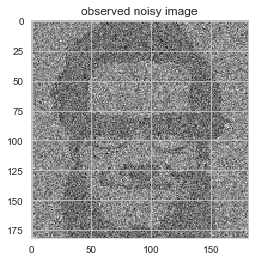

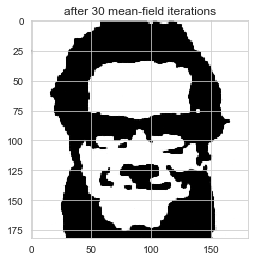

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy.special import expit as sigmoid
from scipy.stats import multivariate_normal

np.random.seed(0)
sns.set_style('whitegrid')

data = Image.open('./images/grey_carl.jpg')
img = np.double(data)
img_mean = np.mean(img)
img_binary = +1*(img>img_mean) + -1*(img<img_mean)
[M, N] = img_binary.shape

#mean-field parameters
sigma  = 2  #noise level
y = img_binary + sigma*np.random.randn(M, N) #y_i ~ N(x_i; sigma^2);
J = 1  #coupling strength (w_ij)
rate = 0.5  #update smoothing rate
max_iter = 30
ELBO = np.zeros(max_iter)
Hx_mean = np.zeros(max_iter)

plt.figure()
plt.imshow(y, cmap='gray')
plt.title("observed noisy image")


#Mean-Field VI
logodds = multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2) - \
          multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2)
logodds = np.reshape(logodds, (M, N))

#init
p1 = sigmoid(logodds)
mu = 2*p1-1  #mu_init

a = mu + 0.5 * logodds
qxp1 = sigmoid(+2*a)  #q_i(x_i=+1)
qxm1 = sigmoid(-2*a)  #q_i(x_i=-1)

logp1 = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2), (M, N))
logm1 = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2), (M, N))

for i in tqdm(range(max_iter)):
    muNew = mu
    for ix in range(N):
        for iy in range(M):
            pos = iy + M*ix
            neighborhood = pos + np.array([-1,1,-M,M])            
            boundary_idx = [iy!=0,iy!=M-1,ix!=0,ix!=N-1]
            neighborhood = neighborhood[np.where(boundary_idx)[0]]            
            xx, yy = np.unravel_index(pos, (M,N), order='F')
            nx, ny = np.unravel_index(neighborhood, (M,N), order='F')
            
            Sbar = J*np.sum(mu[nx,ny])       
            muNew[xx,yy] = (1-rate)*muNew[xx,yy] + rate*np.tanh(Sbar + 0.5*logodds[xx,yy])
            ELBO[i] = ELBO[i] + 0.5*(Sbar * muNew[xx,yy])
        #end for
    #end for
    mu = muNew
            
    a = mu + 0.5 * logodds
    qxp1 = sigmoid(+2*a) #q_i(x_i=+1)
    qxm1 = sigmoid(-2*a) #q_i(x_i=-1)    
    Hx = -qxm1*np.log(qxm1+1e-10) - qxp1*np.log(qxp1+1e-10) #entropy        
    
    ELBO[i] = ELBO[i] + np.sum(qxp1*logp1 + qxm1*logm1) + np.sum(Hx)
    Hx_mean[i] = np.mean(Hx)            
    
plt.figure()
plt.imshow(mu, cmap='gray')
plt.title("after %d mean-field iterations" %max_iter)

In [18]:
cv2.imshow('test',mu)
cv2.waitKey(0)
cv2.destroyAllWindows()